# Weather Prediction With a Hidden Markov Model ☀️☔️

## Background

Knowing the weather in advance is incredibly valuable for a variety of purposes, from transportation (e.g. predicting flight cancellations) to public safety (e.g. issuing severe weather notices) and beyond. However, predicting the weather has always proven elusive, lying somewhere between the often preferred domains of pure chance and an easily foreseen chain of events. Such processes are common in our world, and statisticians have accordingly devised models to assist in the description of such semi-random processes. One such model is the hidden Markov model (HMM), which has applications in such varied domains as speech recognition, biology and finance. Therefore, I will implement HMMs in this notebook to predict weather patterns using real-world data from my hometown of Columbus, Ohio.


## Implementation Details

An HMM of a temporal process (in this case, the weather) makes two key modeling assumptions:

1. The probability of any **observable** outcome (e.g. a rainy day) is exclusively dependent on a **hidden** (unobservable) state of the system (e.g. the movement of every molecule in the sky)


2. The current hidden state of the process **only depends on its recent past** (e.g. yesterday's weather)


It makes sense to use such a model since the weather has a hidden state (the motion of every wind & water current on Earth) that we can attempt to approximate and a series of well-defined outcomes (temperatures, winds, precipitation, etc.) that exclusively depend on that hidden state.

Weather data were gathered from the [National Centers for Environmental Information's Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/) for Jan. 1, 2012 to Dec. 27, 2022, with units given in the imperial system (US standard). The task will involve training models on the data from 2012 - 2020 and testing on 2021 - 2022.

## Exploring & Preparing the Data

We will begin with an exploratory analysis of the data and clean it up for use in training models.

In [2]:
import math
import numpy as np
from scipy.stats import multivariate_normal as mvn

import pandas as pd
import hvplot.pandas
from bokeh.models.formatters import DatetimeTickFormatter
pd.options.plotting.backend = 'holoviews'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import *

%matplotlib inline
plt.rc('figure', dpi=100)
plt.rc('font', size=20)

In [3]:
df = pd.read_csv('weather.csv')
pd.set_option('display.max_columns', None)
df.head()

,STATION,NAME,DATE,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF1,WDF2,WDF5,WDFG,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WT22,WV01
0,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1970-01-01,80.0,90.0,NaN,NaN,NaN,0.00,0.0,0.0,NaN,28,22,NaN,330.0,NaN,NaN,NaN,NaN,NaN,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1970-01-02,30.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,NaN,31,22,NaN,290.0,NaN,NaN,NaN,NaN,NaN,17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1970-01-03,80.0,100.0,NaN,NaN,NaN,0.02,0.0,0.0,NaN,38,25,NaN,310.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1970-01-04,10.0,20.0,NaN,NaN,NaN,0.00,0.0,0.0,NaN,31,23,NaN,300.0,NaN,NaN,NaN,NaN,NaN,17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",1970-01-05,30.0,10.0,NaN,NaN,NaN,0.00,0.0,0.0,NaN,35,21,NaN,270.0,NaN,NaN,NaN,NaN,NaN,19.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.sort_values(by='DATE', inplace=True)
df[df.DATE == '2012-01-01']

,STATION,NAME,DATE,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF1,WDF2,WDF5,WDFG,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WT22,WV01
15340,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2012-01-01,NaN,NaN,11.41,NaN,NaN,0.07,0.0,0.0,NaN,50,38,NaN,NaN,180.0,180.0,NaN,NaN,NaN,NaN,25.1,32.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


This data frame contains the data from all stations in the Columbus Metropolitan Area. However, we see that weather station at John Glenn International Airport appears to report the most data on a daily basis. Therefore, we will use only the data from that station for predictions. Since we are only working with one station, we will exclude the station ID and name from the new data frame.

According to the documentation—which can be found on the same website as the data—, the weather-type (WT##) fields represent specific weather conditions and the dataset appears to use them as binary flags. We will convert all of these fields to sign values ($\pm 1$) for ease of use.

In [5]:
airport_df = df[df.STATION == 'USW00014821'].drop(columns=['STATION', 'NAME'])

flags = [col for col in airport_df.columns if 'WT' in col]
airport_df = airport_df.fillna({f : -1 for f in flags})
airport_df.head()

,DATE,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF1,WDF2,WDF5,WDFG,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WT22,WV01


We observe that the average temperature field is empty for Jan. 1, 2012 - Mar. 31, 2013:

In [6]:
airport_df[airport_df.TAVG.isna()].tail()

,DATE,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF1,WDF2,WDF5,WDFG,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WT22,WV01


This means we have an implementation choice: we can either replace the missing values with an average of the minimum and maximum temperatures for those dates (which are listed) or ignore the average values when training our model. In this project, we will opt for the latter; models will not use the average temperature to make predictions. We will also drop the WDF2 and WDF5 columns, which represent the directions of the fastest wind over two-minute and five-second periods respectively, and rename the weather type columns to be more descriptive.

In [6]:
wt_values = {
    'WT01': 'fog',
    'WT02': 'heavy_fog', # heavy fog
    'WT03': 'thunder', # thunder
    'WT04': 'sleet', # sleet
    'WT05': 'hail',
    'WT06': 'frost', # frost
    'WT08': 'haze',
    'WT09': 'blowing_snow', # blowing or drifting snow
    'WT11': 'high_winds' # high winds
}

rename = {
    'DATE': 'date',
    'AWND': 'avg_wind',
    'PRCP': 'precip',
    'SNOW': 'snow',
    'SNWD': 'snow_depth',
    'TMAX': 'max_temp',
    'TMIN': 'min_temp'
}

airport_df.drop(columns=['TAVG', 'WDF2', 'WDF5'], inplace=True)
airport_df.rename(columns=(wt_values | rename), inplace=True)
airport_df

,date,avg_wind,precip,snow,snow_depth,max_temp,min_temp,fog,heavy_fog,thunder,sleet,hail,frost,haze,blowing_snow,high_winds
50627,2012-01-01,18.12,0.02,0.0,0.0,55.0,32.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50628,2012-01-02,16.78,0.04,0.4,0.0,32.0,23.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50629,2012-01-03,11.63,0.00,0.0,0.0,24.0,18.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
50630,2012-01-04,9.17,0.00,0.0,0.0,35.0,18.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50631,2012-01-05,7.16,0.00,0.0,0.0,45.0,27.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54636,2022-12-23,23.26,0.15,4.9,4.0,33.0,-7.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
54637,2022-12-24,17.22,0.00,0.0,4.0,14.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
54638,2022-12-25,10.29,0.00,0.0,4.0,15.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
54639,2022-12-26,5.59,0.03,0.6,3.0,22.0,7.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0


We have will now create some visualizations of the data.

In [7]:
formatter = DatetimeTickFormatter(months='%b %Y')

temp_plt = airport_df.hvplot(
    x='date', y=['min_temp', 'max_temp'], xformatter=formatter,
    title='Daily High & Low Temperature', xlabel='Date',
    ylabel='Temperature (℉)', kind='scatter', size=10, shared_axes=False
)

prcp_plt = airport_df.hvplot(
    x='date', y=['precip', 'snow'], xformatter=formatter,
    title='Rain & Snowfall', xlabel='Date', ylabel='Precipitation (in.)',
    alpha=[1, 0.75], shared_axes=False
)

wind_plt = airport_df.hvplot(
    x='date', y='avg_wind', xformatter=formatter, title='Daily Average Wind Speed',
    xlabel='Date', ylabel='Avg. wind speed (mph)', shared_axes=False
)

charts = (temp_plt + prcp_plt + wind_plt).cols(1)
hvplot.save(charts, 'rsc/figure1.html')
charts

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Scatter   [date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I      :Curve   [date]   (avg_wind)

As we might expect, the high and low temperatures are highly correlated and oscillate on an annual basis, while precipitation and daily average wind speed are a little more seasonal. Now, we will observe the total number of days on which each weather type occurred.

In [8]:
years = (airport_df.date.max() - airport_df.date.min()).days / 365.25
wt_flags = airport_df[wt_values.values()].replace(-1, 0)

chart = (wt_flags / years).sum().astype('float').hvplot(
    title='Annual Average Weather Pattern Occurrences', ylabel='Days', kind='bar'
)

hvplot.save(chart, 'rsc/figure2.html')
chart

:Bars   [index]   (0)

Some of the most extreme types of weather occur very infrequently, so it will be difficult to obtain a useful model unless we have an extremely large state space. Of course, a model that is too large can easily be overfitted to the data, which is why it is important to test the trained models' abilities to generalize to unseen data.

## Building & Training the Model

Now that we have explored and cleaned the dataset, it is time to build our HMMs using the data. In order to find an optimal model, we will use a variety of hidden-state space sizes. To acheive this, we will create a pipeline to test a variety of such sizes. However, we must first specify the details of how our model is to make predictions.

Most often, a discrete-valued hidden space is utilized, which is what we will do for this project. Each of the finite, enumerable states will have a chance of transitioning to any other on any time step, and the probabilities will be represented by a *transition matrix*, $\mathbf{A}$. For each state pair $i,j$, the probability of transitioning from $j$ to $i$ is given by $P(Z_t = i \,|\, Z_{t-1} = j) = a_{ij}$, where $Z_t$ represents the hidden state on time step $t$. Moreover, the current state *emits* a corresponding observed value $X_t$ (either discrete or continous within a particular range), which is randomly generated according to the state's *emission distribution*. The goal of training the model is to learn the transition matrix and the emission distribution for each state.

### Learning Method

We want to find the model parameters that locally maximize the likelihood of each sequence of observations in the dataset, which we can acheive using the Expectation-Maximization (EM) algorithm. The likelihood of the model parameters $\theta$ given a sequence of observations $\mathbf{x}$ is given by

$$\mathcal{L}(\theta \,|\, \mathbf{x}) = p(\mathbf{x} \,|\, \theta)$$

Maximizing this quantity would typically require maximizing the marginal likelihood (i.e. the likelihood conditioned on each possible hidden sequence), but this is computationally intractable. Hence, we maximize the likelihood function by repeatedly maximizing the expectation of the joint log-likelihood under the current distribution of hidden states conditioned on observations and parameters. This word salad boils down to the following two steps:

$$\mathcal{Q}\left(\theta, \theta^{(t)}\right) = \sum_{\mathbf{z}}
    p\left(\mathbf{z} \,|\, \mathbf{x}, \theta^{(t)}\right) \cdot
    \ln p(\mathbf{x}, \mathbf{z} \,|\, \theta) \qquad \text{expectation}$$

$$\theta^{(t+1)} \gets \underset{\theta}{\arg\max}\:\: \mathcal{Q}\left(\theta, \theta^{(t)}\right)
    \qquad \text{maximization}$$

Using Bayes' theorem, we can decompose the conditional distribution as follows:

$$p\left(\mathbf{z} \,|\, \mathbf{x}, \theta^{(t)}\right) \propto
    p\left(\mathbf{x} \,|\, \mathbf{z}, \theta^{(t)}\right) \cdot
    p\left(\mathbf{z} \,|\, \theta^{(t)}\right)
= \prod_{k=1}^n p(x_k | z_k) \cdot p(z_1) \cdot \prod_{k=2}^n p(z_k | z_{k-1})$$

### Observed Variable Representation

Normally, HMMs also have a discrete observation space; however, instead of employing a binning strategy (i.e. grouping temperatures into ranges), we will use a continuous model for observations. We can treat all of the components of each observation as a single multivariate normal variable $X_i \sim \mathcal{N}(\mu_i, \Sigma_i)$ with parameters determined by the hidden state, $i$, in which we determine the outcomes of Bernoulli components via the sign of their corresponding entries.

This allows our model to take correlations between all observed components into account, reducing the need for a large state space. We should expect that there are some correlations between these components; for example, we would expect snow to be positively correlated with low temperatures and negatively correlated with thunder. Therefore, to train our model, we need to learn the transition matrix and the normal parameters $\mu_i, \Sigma_i$ for each hidden state $i$.

We need a way to represent binary observations as continuous ones for the purposes of learning the parameters. For this reason, we will map each positive instance of a weather-type variable to 1 and each negative instance to -1. This will force training to focus on learning the mean (acting as a classification threshold) and covariance (interactions between different observed components).

### Maximizing the Likelihood

Using these assumptions, we can more completely express our approximated log-likelihood function as

$$\mathcal{Q}\left(\theta, \theta^{(t)}\right) = \sum_{\mathbf{z}}
    w(\mathbf{z}) \cdot \left[\ln p(\mathbf{x} \,|\, \mathbf{z}, \theta)
    + \ln p(\mathbf{z} \,|\, \theta)\right]$$

$$= \sum_{\mathbf{z}} w_t(\mathbf{z}) \cdot \left[
    \sum_{k=1}^n \ln \mathcal{N}(x_k \,|\, \mu(z_k), \mathbf{\Sigma}(z_k))
    + \ln \pi(z_1) + \sum_{k=2}^n \ln \mathbf{A}(z_k, z_{k-1})\right]$$

where $w_t(\mathbf{z}) = p\left(\mathbf{z} \,|\, \mathbf{x}, \theta^{(t)}\right)$ is the constant weight assigned to each joint log-likelihood given a particular hidden sequence and $\pi$ is the initial distribution of states.

With the Q-function expressed in this manner and assuming we will optimize the expression via gradient ascent with learning rate $\eta$, it becomes apparent that we can separately learn the emission distribution parameters, the initial state distribution, and the transition matrix on each M-step. Out of these three, it is easiest to learn the initial state distribution.

$$\frac{\partial \mathcal{Q}\left(\pi, \theta^{(t)}\right)}{\partial \pi(s)}
    = \sum_{\mathbf{z}: z_1 = s} \frac{w_t(\mathbf{z})}{\pi(s)}$$

$$\tilde\pi \gets \pi^{(t)} + \eta \nabla \mathcal{Q}(\pi, \theta^{(t)}), \qquad
    \pi^{(t+1)} \gets \frac{\tilde\pi}{||\tilde\pi||_1}$$

On each step every component appears to increase, yet does not really as the entire vector is then L1-normalized (constrained to be a probability distribution). Next, we derive the update step for the transition matrix:

$$\frac{\partial \mathcal{Q}\left(\mathbf{A}, \theta^{(t)}\right)}{\partial a_{ij}}
    = \sum_{\mathbf{z}} \frac{w_t(\mathbf{z}) \cdot N_{ij}(\mathbf{z})}{a_{ij}}
    \qquad \text{where } N_{ij}(\mathbf{z}) \text{ is the number of occurrences of } j \to i \text{ in } \mathbf{z}$$

$$\mathbf{\tilde A} \gets \mathbf{A}^{(t)} + \eta \nabla \mathcal{Q}(\mathbf{A}, \theta^{(t)}),
    \qquad \mathbf{A}_j^{(t+1)} \gets \frac{\mathbf{\tilde A}_j}{||\mathbf{\tilde A}_j||_1}$$

Finally, we derive the update steps for the normal distribution parameters.

$$\frac{\partial \mathcal{Q}\left(\mu, \theta^{(t)}\right)}{\partial \mu(s)}
    = \sum_{\mathbf{z}} w_t(\mathbf{z}) \cdot \sum_{k: z_k = s}
    \mathbf{\Sigma}(s)^{-1} \left[x_k - \mu(s)\right]$$

$$\mu^{(t+1)} \gets \mu^{(t)} + \eta \nabla \mathcal{Q}(\mu, \theta^{(t)})$$

To derive the formula for the covariance matrix update step, we use the facts that

$$\frac{\partial \ln \det(\mathbf{X})}{\partial \mathbf{X}}
    = 2\mathbf{X}^{-1} - \mathbf{X}^{-1} \circ \mathbf{I} \quad \text{and} \quad
    \frac{\partial \mathbf{a}^T \mathbf{X}^{-1} \mathbf{a}}{\partial \mathbf{X}}
    = \mathbf{X}^{-1} \mathbf{a} (\mathbf{X}^{-1} \mathbf{a})^T \circ \mathbf{I}
    - 2\mathbf{X}^{-1} \mathbf{a} (\mathbf{X}^{-1} \mathbf{a})^T$$

for symmetric $\mathbf{X}$ (found in [The Matrix Cookbook](http://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf)) and that $\mathbf{\Sigma}$ is positive semi-definite.

$$\frac{\partial \mathcal{Q}\left(\mathbf{\Sigma}, \theta^{(t)}\right)}{\partial \mathbf{\Sigma}(s)}
    = \frac{1}{2} \sum_{\mathbf{z}} w_t(\mathbf{z}) \cdot \sum_{k: z_k = s}
    \left[\mathbf{M} \circ \mathbf{I} - 2\mathbf{M}\right] \qquad \text{where }
    \mathbf{M} = \mathbf{\Sigma}^{-1} - \mathbf{\Sigma}^{-1} (x_k - \mu(s))(x_k - \mu(s))^T \mathbf{\Sigma}^{-1}$$
    
### Practical Measures

Instead of computing these gradients by summing over all possible hidden sequences, we will approximate these quantities by instead summing over random samples drawn from the set of possible hidden sequences. Once training has progressed to a certain extent, we do not want to sample over uniformly generated samples (which will become incredibly improbable). However, we also wish to maintain some level of uncertainty in our choices, because the transition matrix may collapse to nearly the identity matrix. Therefore, we will sample each state from the softmax of the previous state's transition distribution, ensuring that relatively likely (but varied) sequences are generated.

Moreover, because there are known closed-form solutions for the maximum-likelihood estimators (MLEs) of the parameters of a multivariate normal distribution, we will replace gradient descent by a roughly equivalent update rule. Rather than ascend the gradient with fixed steps towards an MLE we already know how to compute, we will simply allow the current parameter values to exponentially "decay" towards that value, so we will not need to change our step size or use any modified gradient ascent techniques to adjust the "scale" of their shift. Let $0 < \gamma \ll 1$.

$$\mu^{(t+1)}(s) \gets (1 - \gamma) \cdot \mu^{(t)}(s) + \gamma
    \cdot \frac{\sum_{\mathbf z} w_t(\mathbf{z})
    \cdot \bar{\mathbf x}_s}{\sum_{\mathbf z} w_t(\mathbf{z})}
    \qquad \text{where } \bar{\mathbf x}_s \text{ is the sample mean over all } x_k: z_k = s$$

$$\mathbf{\Sigma}^{(t+1)}(s) \gets (1 - \gamma) \cdot \mathbf{\Sigma}^{(t)}(s)
    + \gamma \cdot \frac{\sum_{\mathbf z} w_t(\mathbf{z})
    \cdot \mathbf{S}_s}{\sum_{\mathbf z} w_t(\mathbf{z})}
    \qquad \text{where } \mathbf{S}_s \text{ is the sample covariance over all } x_k: z_k = s$$
    
As is traditional for Gaussian mixture models, we will initialize emission parameters by drawing samples from the data to be our means and randomly initializing the covariance matrices.
    
### Class Definition & Using the Trained Model

In this implementation, we use a modified version of the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) to identify the most likely sequence of hidden states associated with observations, which then allows us to predict corresponding probable future observations. We define a class to represent our HMM below.

In [9]:
import math
import numpy as np
from scipy.stats import multivariate_normal as mvn

class HMM:
    def __init__(self, h=5):
        '''
        Initializes a new Hidden Markov Model.
        
        Parameters
        ----------
        h (int) : The number of hidden states. Defaults to 5.
        '''
        self.h = h
        self.d = self.p = self.A = self.m = self.S = None # untrained
        
    def fit(self, X, seq_len=None, samps=None, r=1e-4, g=0.05, steps=1000):
        '''
        Fits this HMM to the given data.
        
        Parameters
        ----------
            X (ndarray)   : The observation data on which to train.
            seq_len (int) : The length of each training sequence. Defaults to None.
                            If None, math.ceil(math.sqrt(len(X))) is used.
            samps (int)   : The number of hidden sequences to generate on each step.
                            If None, the number of hidden states is used.
                            Defaults to None.
            r (float)     : The learning rate for gradient ascent. Defaults to 1e-4.
            g (float)     : The complement of the decay rate for learning normal
                            parameters. Defaults to 0.01.
            steps (int)   : The maximum number of training steps to take.
                            Defaults to 1000.
            
        Returns: A tuple (p, A, m, S) containing the model parameters.
                 p = initial distribution, A = transition matrix,
                 m = means per state, S = covariance matrices per state
        '''
        # observation data length & dimensionality
        n, d = X.shape if len(X.shape) == 2 else (len(X), 1)
        self.d = d
        h = self.h
        
        # initialize model parameters
        p = np.exp(np.random.normal(size=self.h)) # initial distribution
        p /= np.sum(p)
        A = np.exp(np.eye(h) + np.random.sample(size=(h,h))) # transition matrix
        A /= np.sum(A, axis=0)
        m = X[np.random.choice(len(X), h)] # means
        S = np.random.normal(size=(h,d,d)) # covariances
        S = S @ S.transpose([0,2,1])
        
        # reset seq_len if None
        if seq_len is None:
            seq_len = math.ceil(math.sqrt(n))
            
        # reset samps if None
        if samps is None:
            samps = h
        
        # compute likelihood/weight of sample sequence
        def log_weight(x, z, log=False):
            # joint log-pdf over observations
            log_px = [mvn.logpdf(o, m[z[t]], S[z[t]],
                                 allow_singular=True) for t,o in enumerate(x)]
            log_px = np.sum(log_px)
            
            # log-probability of hidden sequence
            log_init = np.log(p[z[0]])
            p_trans = [A[z[t], z[t-1]] for t in range(1,len(x))]
            log_pz = log_init + np.sum(np.log(p_trans))
            
            # joint log-probability of sequences
            return log_px + log_pz
        
        # sample a hidden sequence using softmax of transition distributions
        def samp_seq():
            seq = [np.random.choice(h, p=p)]
            T = np.exp(A)
            T /= np.sum(T, axis=0)
            for i in range(1, seq_len):
                seq.append(np.random.choice(h, p=T[:,seq[i-1]]))
            return np.array(seq)
        
        # perform EM steps
        for start in np.random.choice(n - seq_len + 1, steps):
            x = X[start : start + seq_len]
            hid_seqs = np.random.choice(h, size=(samps, seq_len))
            log_w = np.array([log_weight(x, hid_seqs[i]) for i in range(samps)])
            w = np.exp(log_w - np.max(log_w))
            
            # update parameters
            dp = np.zeros(shape=p.shape)
            dA = np.zeros(shape=A.shape)
            total_m = np.zeros(shape=m.shape)
            total_S = np.zeros(shape=S.shape)
            total_w = np.zeros(shape=h)
            
            for i, z in enumerate(hid_seqs):
                dp[z[0]] += w[i] / (p[z[0]] + 1e-6)
                for j in range(1, seq_len):
                    dA[z[j], z[j-1]] += w[i] / (A[z[j], z[j-1]] + 1e-6)
                for s in range(h):
                    if np.sum(z == s):
                        total_m[s] += w[i] * np.mean(x[z == s], axis=0)
                        total_S[s] += w[i] * np.cov(x[z == s], rowvar=False)
                        total_w[s] += w[i]
                        
            # Markov parameters
            p += r * dp
            p /= np.sum(p)
            A += r * dA
            A /= np.sum(A, axis=0)
            
            # handle rare occurrences
            unencountered = total_w == 0
            total_w[unencountered] = 1
            total_m[unencountered] = m[unencountered]
            total_S[unencountered] = S[unencountered]
            
            # distribution parameters
            target_m = total_m / total_w.reshape(-1, 1)
            target_S = total_S / total_w.reshape(-1, 1, 1)
            m = (1 - g) * m + g * target_m
            S = (1 - g) * S + g * target_S
        
        self.p = p.copy()
        self.A = A.copy()
        self.m = m.copy()
        self.S = S.copy()
        return (p, A, m, S)
    
    def predict_hidden(self, n=1, obs=None, hid=None, sample=False):
        '''
        Predicts the next n most likely hidden states, based on previous
        observations or hidden states. Uses the Viterbi algorithm to
        find the most likely hidden sequence associated with observations.
        Either samples stochastically from Markov chain or follows most
        likely transitions to make a prediction.
        
        Parameters
        ----------
            n (int)              : The number of states to predict. Defaults to 1.
            obs (ndarray)        : A list of previous observations on which to base predictions.
                                   Defaults to None.
            hid (ndarray or int) : The last hidden state(s) on which to base predictions.
                                   Defaults to None. Overrides any information provided by obs.
            sample (bool)        : Samples stochastically from Markov chain if True,
                                   otherwise follows the most likely transitions.
                                   Defaults to False.
                                   
        Returns: The most likely sequence of sucessive hidden states or
                 None if the model is untrained.
        '''
        if self.d is None:
            return None
        
        # param aliases for readability
        h = self.h
        d = self.d
        p = self.p
        A = self.A
        m = self.m
        S = self.S
        
        if type(hid) == int:
            next_state = np.argmax(A[:, hid])
        elif hid is not None:
            next_state = np.argmax(A[:, hid[-1]])
        elif obs is None:
            next_state = np.argmax(p)
        else:
            # find the hidden state sequence that maximizes likelihood
            o = np.reshape(obs, (-1,d))
            T = o.shape[0]
            
            # reduced Viterbi algorithm (no need to track path)
            prev = [
                mvn.logpdf(o[0], m[s], S[s], allow_singular=True) for s in range(h)
            ]
            prev = np.array(prev) + np.log(p + 1e-6)
            
            # repeatedly find previous state to maximize total likelihood
            for t in range(1,T):
                # current log-likelihood
                curr = np.array([
                    mvn.logpdf(o[t], m[s], S[s], allow_singular=True) for s in range(h)
                ])
                for s in range(h):
                    l = prev + np.log(A[s] + 1e-6)
                    k = np.argmax(l)
                    curr[s] += l[k]
                prev = curr

            next_state = np.argmax(prev)

        states = []
        while len(states) < n:
            if sample:
                next_state = np.random.choice(h, p=A[:, next_state])
            else:
                next_state = np.argmax(A[:, next_state])
            states.append(next_state)
        return np.array(states)
    
    def predict(self, n=1, obs=None, hid=None, hid_sample=False, obs_sample=True):
        '''
        Predicts the next n observations by finding the most likely
        hidden states associated with previous observations or
        accepting those provided, and then either sampling from
        the Markov chain / emission distributions respectively or
        picking their most likely outcomes
        
        Parameters
        ----------
            n (int)              : The number of states to predict. Defaults to 1.
            obs (ndarray)        : A list of previous observations on which to base predictions.
                                   Defaults to None.
            hid (ndarray or int) : The last hidden state(s) on which to base predictions.
                                   Defaults to None. Overrides any information provided by obs.
            hid_sample (bool)    : Samples stochastically from Markov chain if True,
                                   otherwise follows the most likely transitions.
                                   Defaults to False.
            obs_sample (bool)    : Samples stochastically from emission distribution
                                   if True, otherwise returns distribution mean.
                                   Defaults to True.
                                   
        Returns: The most likely sequence of sucessive observations or
                 None if the model is untrained.
        '''
        if self.d is None:
            return None
        
        # retrieve hidden states
        h_pred = self.predict_hidden(n, obs, hid, hid_sample)
        
        if obs_sample:
            return np.array([mvn.rvs(self.m[s], self.S[s]) for s in h_pred])
        else:
            return self.m[h_pred]

In [10]:
# get the date of the cutoff for training
cutoff = airport_df[airport_df.date == '2021-01-01'].index.item()
cutoff -= airport_df.index.min().item()
cutoff

# create training and test sets
X = airport_df.drop(columns='date').to_numpy()
X_train = X[:cutoff]
X_test = X[cutoff:]

With these data, we will train an ensemble of relatively small models and compare them with a single larger one to determine which obtains more realistic forecasts.

In [11]:
# train an ensemble of small models

ensemble = [HMM(5) for i in range(4)]
ensemble_params = []
for model in ensemble:
    ensemble_params.append(model.fit(X_train, seq_len=5))

# train a single large model
hmm = HMM(20)
hmm_params = hmm.fit(X_train, seq_len=5, steps=2000)

## Testing the Model

Now that we have trained our ensemble and large model respectively on the data from 2012-2020, we will examine their structures and test their effectiveness on the data from 2021-2022. First, we show their accuracy on 1-, 3-, and 5-day forecasts compared to the ground truth. For each forecast length, we will also vary the length of the previous observation, feeding the models 1-7 days of prior history from which to base their predictions.

The accuracy will be computed by sampling 200 starting days for the history and taking the mean squared error (MSE) of the predictions. Moreover, predictions will be made by taking the distribution means for the sake of observing which model is more accurate on average. Lastly, we will consider the quantitative and categorical components of the observations separately.

In [12]:
forecast_lengths = [1, 3, 5]
types = ['Quantitative', 'Categorical']
models = ['HMM Ensemble', 'Large HMM']

# constants
cat = 6
week = 7
pred_samples = 200

# create an array to store mse values
mse = np.empty(shape=(len(types), len(forecast_lengths), 2*week, len(models)))

for idx, l in enumerate(forecast_lengths):
    for hist_len in 1 + np.arange(2*week):
        # generate history beginnings
        starts = np.random.choice(len(X_test) - hist_len - l + 1, pred_samples)
        
        # set error counters to 0
        mse_q = np.zeros(shape=2)
        mse_c = np.zeros(shape=2)
        
        # compute MSE per data type over samples
        for s in starts:
            hist = X_test[np.arange(s, s + hist_len)]
            # make predictions
            ens_pred = np.array([
                model.predict(n=l, obs=hist) for model in ensemble
            ])
            ens_pred = np.mean(ens_pred, axis=0)
            hmm_pred = hmm.predict(n=l, obs=hist)
            
            # convert continuous predictions to discrete
            ens_pred[:,cat:] = np.sign(ens_pred[:,cat:])
            hmm_pred[:,cat:] = np.sign(hmm_pred[:,cat:])
            
            # record prediction errors
            ground_truth = X_test[s + hist_len : s + hist_len + l]
            ens_diff = ens_pred - ground_truth
            hmm_diff = hmm_pred - ground_truth
            mse_q += (np.linalg.norm(ens_diff[:,:cat]),
                      np.linalg.norm(hmm_diff[:,:cat]))
            mse_c += (np.linalg.norm(ens_diff[:,cat:]),
                      np.linalg.norm(hmm_diff[:,cat:]))
        mse_q /= pred_samples
        mse_c /= pred_samples
        mse[:, idx, hist_len - 1, :] = np.array([mse_q, mse_c])

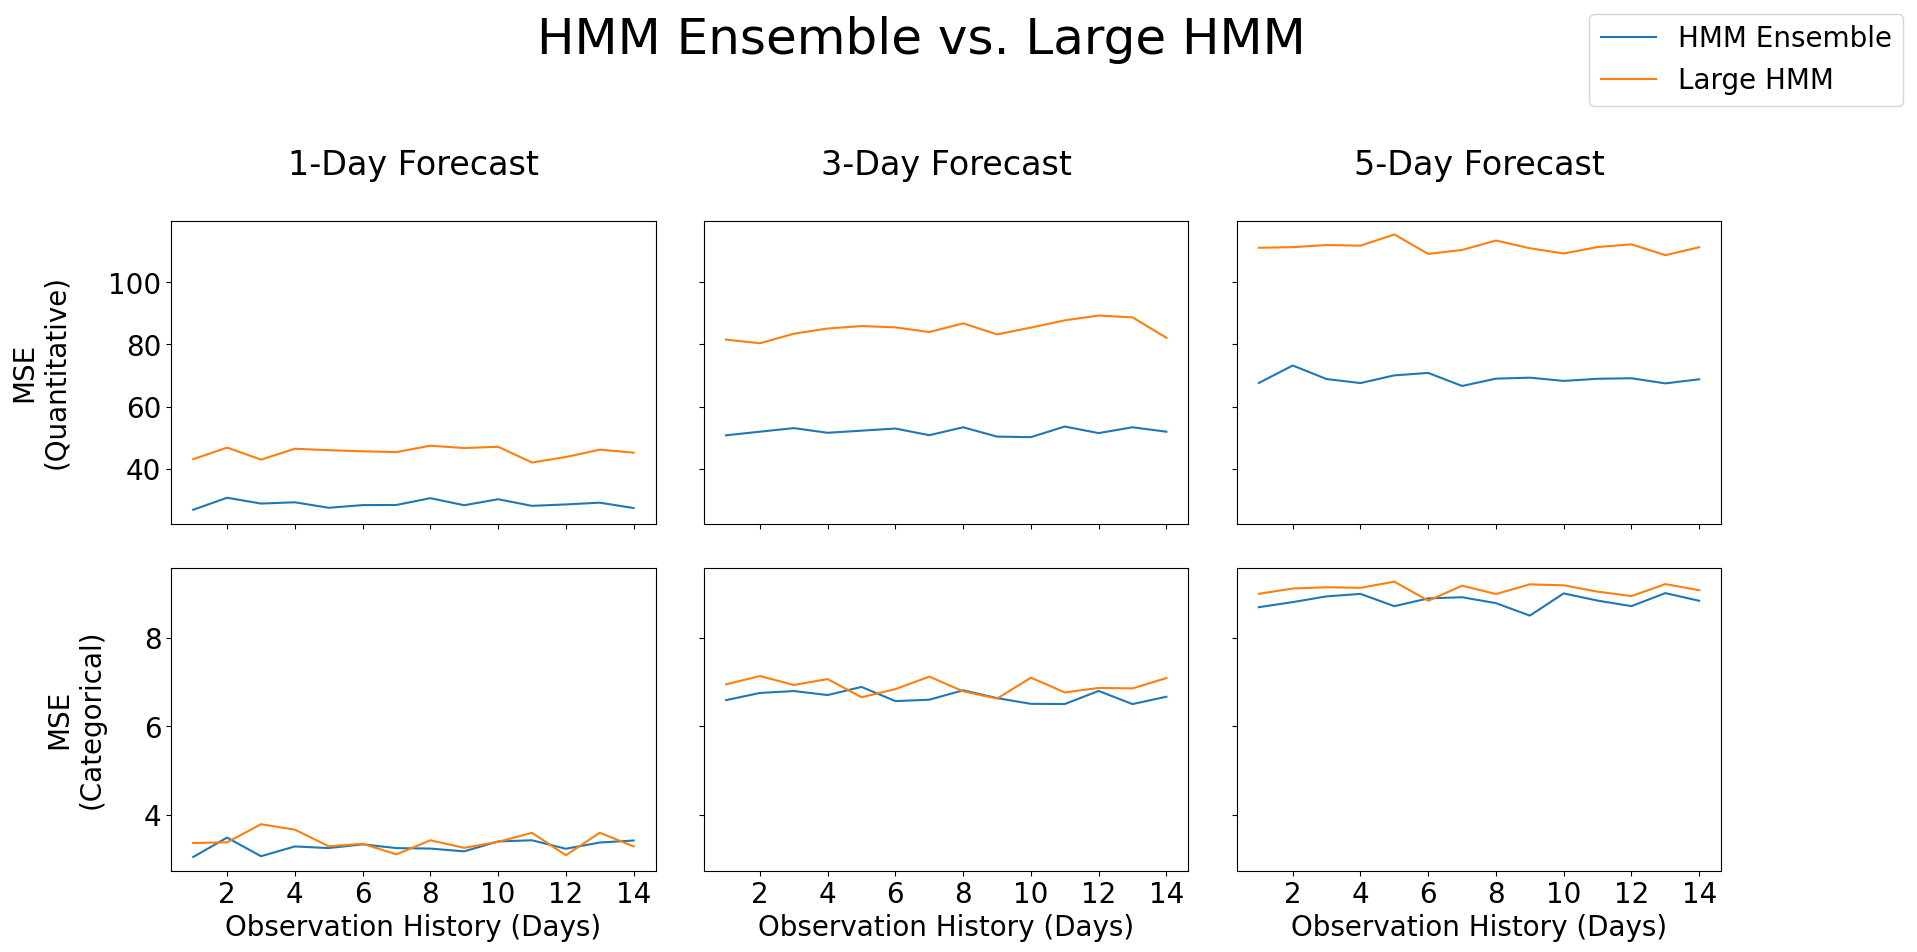

In [13]:
fig, axs = plt.subplots(len(types) + 1, len(forecast_lengths), figsize=(20,10),
                        sharex='col', sharey='row', height_ratios=[1,5,5])
fig.subplots_adjust(wspace=0.1)

for r,t in enumerate(types):
    axs[r+1,0].set_ylabel(f'MSE\n({t})\n')

for c,l in enumerate(forecast_lengths):
    axs[-1,c].set_xlabel('Observation History (Days)')
    axs[-1,c].xaxis.set_major_locator(ticker.MultipleLocator(2))

for c,l in enumerate(forecast_lengths):
    axs[0,c].set_axis_off()
    axs[1,c].set_title(f'{l}-Day Forecast\n')

for r,t in enumerate(types):
    for c,l in enumerate(forecast_lengths):
        axs[r+1,c].plot(1 + np.arange(2*week), mse[r,c])
        
fig.legend(models)
fig.suptitle('HMM Ensemble vs. Large HMM', fontsize=36)
plt.savefig('rsc/figure3.png', transparent=False)

In this graph, we see that feeding the models more weather history has no effect on the error. This is likely because the models only rely upon the last observed state to generate predictions, and one observed day is sufficient to guess that state. We also note that, as we might expect, the prediction error increases as we extend our forecast length. Nonetheless, another trend emerges: the ensemble of smaller models consistently outperforms the single larger one with respect to continuous variables (temperature, precipitation, & wind) but the two have a nearly identical performance on categorical (weather-type) ones.

## Interpretting Model Parameters

We can learn about the respective structures of these models by visualizing their parameters.

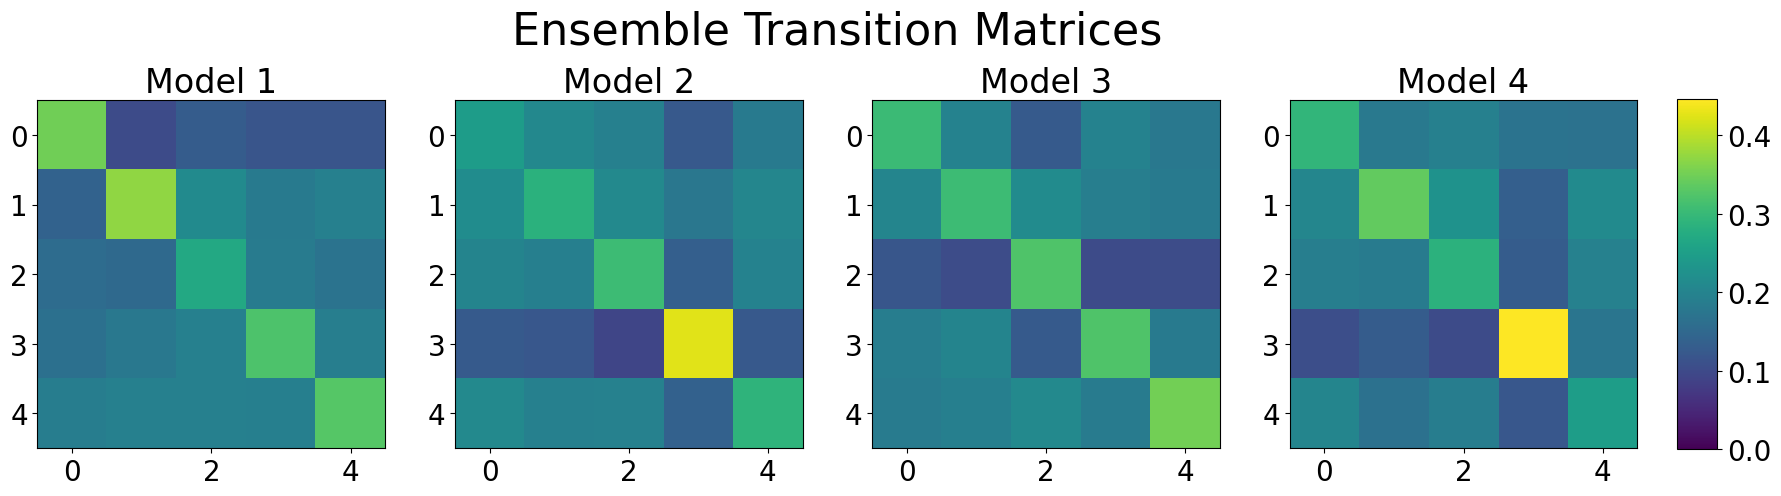

In [14]:
fig, axes = plt.subplots(1, len(ensemble), figsize=(20,5))
fig.suptitle('Ensemble Transition Matrices', fontsize=32)

max_t = np.max([ensemble_params[i][1] for i,_ in enumerate(ensemble)])
for i,_ in enumerate(ensemble):
    im = axes[i].imshow(ensemble_params[i][1], vmin=0, vmax=max_t)
    axes[i].set_title(f'Model {i+1}')
    
fig.subplots_adjust(bottom=0.05, top=0.85, left=0.1, right=0.9)
cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.7])
fig.colorbar(im, cax=cb_ax)

plt.savefig('rsc/figure4.png', transparent=False)

As we expect, if we create models that assume there are only five types of weather per year, most consecutive days will have the same weather type. This is why the main diagonal (representing transitions from each state to itself) have the highest values.

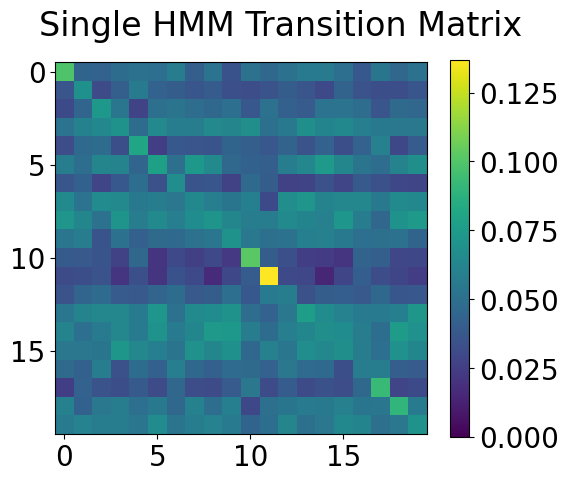

In [15]:
fig = plt.figure(figsize=(6,5))
fig.suptitle('Single HMM Transition Matrix', fontsize=24)

im = plt.imshow(hmm_params[1], vmin=0)
fig.colorbar(im, ax=fig.get_axes())

plt.savefig('rsc/figure5.png', transparent=False)

For the large model, we observe that a similar trend emerges of self-transitions being most probable. We might also notice that some rows have particularly high or low values. These represent states that have high and low chances respectively of being transitioned to from other states, the latter of which may allow the model to represent unlikely, but nonetheless relevant, weather conditions. The extent to which the matrix is symmetric (across the main diagonal) allows us to visualize which states are likely to be "grouped" together (e.g. sunny and hazy days in the same temperature range).

## Sample Forecasts For Random Date Ranges

To see the models in action, let us generate predictions for specific date ranges. We will create the most accurate three-day forecasts possible using the learned parameters. These predictions will be formatted as numpy arrays, with the first three days representing the histories fed to the model and the latter three representing their predictions, then graphed below.

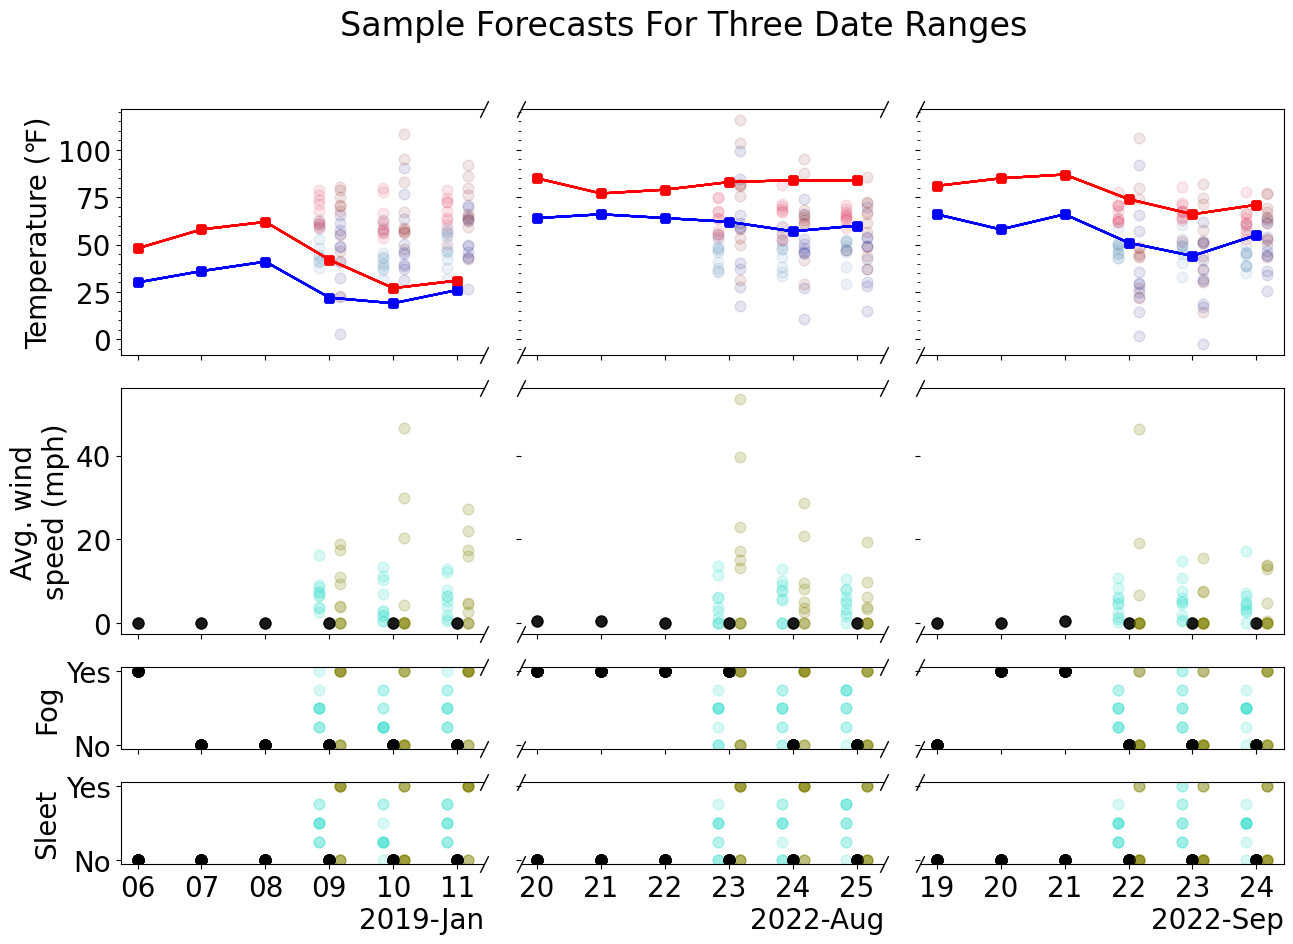

In [23]:
# relevant column indices
min_temp = airport_df.columns.get_loc('min_temp') - 1
max_temp = airport_df.columns.get_loc('max_temp') - 1
precip = airport_df.columns.get_loc('precip') - 1
fog = airport_df.columns.get_loc('fog') - 1
sleet = airport_df.columns.get_loc('sleet') - 1

# starting indices for observed histories
start_indices = np.random.choice(len(X) - 6, 3, replace=False)
start_indices.sort()

# keep track of forecasts (1 per row)
fig, axes = plt.subplots(4, len(start_indices), figsize=(15,10),
                         sharex='col', sharey='row', height_ratios=[3,3,1,1])
fig.subplots_adjust(wspace=0.1)

# format dates
for ax in axes.ravel():
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# make broken axes for different date ranges
gap_line = dict(
    marker=[(-0.5, -1), (0.5, 1)], markersize=12,
    linestyle='none', color='k', mec='k', mew=1, clip_on=False
)

# make gaps in axes
for ax in axes[:, :-1].ravel():
    ax.spines.right.set_visible(False)
    ax.tick_params(labelright=False)
    ax.plot([1,1], [0,1], transform=ax.transAxes, **gap_line)
for ax in axes[:, 1:].ravel():
    ax.spines.left.set_visible(False)
    ax.tick_params(labelleft=False)
    ax.plot([0,0], [0,1], transform=ax.transAxes, **gap_line)

# color mappings for each graphed data type
temp_colors = {
    'obs_min': 'blue', 'obs_max': 'red',
    'ens_min': 'steelblue', 'ens_max': 'crimson',
    'hmm_min': 'navy', 'hmm_max': 'maroon'
}
prcp_colors = {
    'obs': 'black', 'ens': 'turquoise', 'hmm': 'olive'
}
wt_colors = {
    'obs_fog': 'black', 'obs_sleet': 'black',
    'ens_fog': 'turquoise', 'ens_sleet': 'turquoise',
    'hmm_fog': 'olive', 'hmm_sleet': 'olive'
}

# graph the forecasts for each randomly sampled date range
for idx, start in enumerate(start_indices):
    # array of dates
    dates = np.array([airport_df.date.min() for d in range(6)])
    dates += [timedelta(days=int(d)) for d in start + np.arange(6)]
    
    # history / ground truth observations
    hist = X[start + np.arange(6)]
    
    # create data frames
    temp = pd.DataFrame(columns=[
        'obs_min', 'ens_min','hmm_min',
        'obs_max', 'ens_max', 'hmm_max'
    ])
    prcp = pd.DataFrame(columns=[
        'obs', 'ens', 'hmm'
    ])
    wt = pd.DataFrame(columns=[
        'obs_fog', 'ens_fog', 'hmm_fog',
        'obs_sleet', 'ens_sleet', 'hmm_sleet'
    ])
    
    for sample in range(10):
        # ensemble prediction
        ens_pred = np.array([
            model.predict(n=3, obs=hist[:3]) for model in ensemble
        ])
        ens_pred[ens_pred[:,:,precip] < 0, precip] = 0
        ens_pred[:,:,cat:] = np.sign(ens_pred[:,:,cat:])
        ens_pred = np.mean(ens_pred, axis=0)

        # lone hmm prediction
        hmm_pred = hmm.predict(n=3, obs=hist[:3])
        hmm_pred[hmm_pred[:,precip] < 0, precip] = 0
        hmm_pred[:,cat:] = np.sign(hmm_pred[:,cat:])

        # populate data frames
        temp[['obs_min', 'obs_max']] = hist[:, [min_temp, max_temp]]
        temp.loc[3:5, ['ens_min', 'ens_max']] = ens_pred[:, [min_temp, max_temp]]
        temp.loc[3:5, ['hmm_min', 'hmm_max']] = hmm_pred[:, [min_temp, max_temp]]
        prcp['obs'] = hist[:, precip]
        prcp.loc[3:5, ['ens']] = ens_pred[:, precip]
        prcp.loc[3:5, ['hmm']] = hmm_pred[:, precip]
        wt[['obs_fog', 'obs_sleet']] = hist[:, [fog, sleet]]
        wt.loc[3:5, ['ens_fog', 'ens_sleet']] = ens_pred[:, [fog, sleet]]
        wt.loc[3:5, ['hmm_fog', 'hmm_sleet']] = hmm_pred[:, [fog, sleet]]
        
        # compose into a single figure
        for col in temp.columns:
            if 'obs' not in col:
                if 'hmm' in col:
                    offset = timedelta(hours=4)
                elif 'ens' in col:
                    offset = timedelta(hours=-4)
                axes[0,idx].scatter(dates + offset, temp[col], label=col,
                                    c=temp_colors[col], marker='o', s=60, alpha=0.1)
            else:
                axes[0,idx].plot(dates, temp[col], label=col,
                                        c=temp_colors[col], marker='s', ls='-')
        for col in prcp.columns:
            if 'obs' in col: offset = timedelta()
            elif 'ens' in col: offset = timedelta(hours=-4)
            else: offset = timedelta(hours=4)
            axes[1,idx].scatter(dates + offset, prcp[col], label=col,
                                c=prcp_colors[col], s=60, alpha=0.2)
        for col in wt.columns:
            if 'fog' in col:
                if 'obs' in col:
                    a = 1
                    offset = timedelta()
                elif 'ens' in col:
                    a = 0.2
                    offset = timedelta(hours=-4)
                else:
                    a = 0.2
                    offset = timedelta(hours=4)
                axes[2,idx].scatter(dates + offset, wt[col], label=col,
                                    c=wt_colors[col], s=60, alpha=a)
            elif 'sleet' in col:
                if 'obs' in col:
                    a = 1
                    offset = timedelta()
                elif 'ens' in col:
                    a = 0.2
                    offset = timedelta(hours=-4)
                else:
                    a = 0.2
                    offset = timedelta(hours=4)
                axes[3,idx].scatter(dates + offset, wt[col], label=col,
                                    c=wt_colors[col], s=60, alpha=a)

# label y-axes and set y-axis tickers
axes[0,0].set_ylabel('Temperature (℉)')
axes[0,0].yaxis.set_major_locator(ticker.MultipleLocator(25))
axes[0,0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
axes[1,0].set_ylabel('Avg. wind\nspeed (mph)')
axes[1,0].yaxis.set_major_locator(ticker.AutoLocator())
axes[2,0].set_ylabel('Fog')
bin_loc = ticker.FixedLocator([-1,1])
bin_frm = ticker.FixedFormatter(['No', 'Yes'])
axes[2,0].yaxis.set_major_locator(bin_loc)
axes[2,0].yaxis.set_major_formatter(bin_frm)
axes[3,0].set_ylabel('Sleet')
axes[3,0].yaxis.set_major_locator(bin_loc)
axes[3,0].yaxis.set_major_formatter(bin_frm)
fig.suptitle('Sample Forecasts For Three Date Ranges')
plt.savefig('rsc/figure6.png', transparent=False)

The above visualizations represent learned forecast distributions conditioned on prior histories. Scattered points on the left of each main data point are predictions made by the ensemble, whereas those to the right are produced by the single HMM.

We can see that the lone model produces forecasts with greater variance (uncertainty) than the ensemble, which is expected because we can be more confident in the mean output of multiple models than the output of just one. For weather type quantities, we can interpret the ensemble's Yes/No predictions by which value it tends towards on a given day. The uncertainty of each model reflects the volatility of the weather in Columbus which, from personal experience, can seemingly change course on any given day.

## Conclusion

Overall, the models have learned the distribution of weather in Columbus to a reasonable extent, but probably not to a sufficient degree to predict the weather for safety/commercial purposes. In order to achieve such results, it seems prudent to train a large ensemble of mid-sized models (perhaps with ~8 hidden states each), and possibly to perform linear regression on their component-wise individual outputs to predict the weather to a much greater degree of accuracy. Training such an ensemble is ultimately more efficient than trying to learn the parameters of a single larger model, as the training time of the former grows linearly with the number of models while that of the latter grows quadratically with the number of hidden states. Finally, provided more data (e.g. from nearby cities), the accuracy of this model could be greatly improved.